In [ ]:
pip install qiskit

In [ ]:
pip install qiskit-aer-gpu-cu11

In [2]:
from spin import *

In [3]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import DensityMatrix, Statevector, SparsePauliOp, Operator
from qiskit.quantum_info import partial_trace as partial_trace_qiskit
from qiskit.quantum_info import entropy as entropy_qiskit 

import numpy as np
# from trotter import *
import time

In [3]:
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, amplitude_damping_error)

In [ ]:
p_gate = 0.01

error_x = pauli_error([('X', p_gate), ('I', 1 - p_gate)]) 
error_depolarizing = depolarizing_error(p_gate, 1) 
error_dephasing = pauli_error([('Z', p_gate), ('I', 1 - p_gate)]) 


In [4]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
import numpy as np

def init_system(n): 
    n = n

    QIMF = Nearest_Neighbour_1d(n, hx=0.8090, hy=0.9045, Jx=1, pbc=False)
    # powerlaw = Power_Law(n, alpha=4, Jx=1, Jy=1, Jz=1, hx=1, hy=1, hz=1, pbc=False, verbose=True)

    H = QIMF.ham_xyz
    # H = powerlaw.ham_xyz
    print(H)

    init = Statevector.from_label("00"*int(n/2))
    t = 10
    r = 100
    m = 1
    dt = (t / r)
    dt2 = (t / (r*m))

    print(dt, dt2)
    return H, init, n, r, m, dt, dt2

In [5]:
import numpy as cp
from typing import List

def partial_trace(rho: cp.ndarray, keep: List[int], n_qubits: int) -> cp.ndarray: 
    dims = [2] * n_qubits
    perm = keep + [i for i in range(n_qubits) if i not in keep]

    rho = rho.reshape(dims + dims)
    rho = rho.transpose(perm + [i + n_qubits for i in perm])
    dim_keep = 2**len(keep)
    dim_traced = 2**(n_qubits - len(keep))

    rho = rho.reshape(dim_keep, dim_traced, dim_keep, dim_traced)

    rho_A = cp.trace(rho, axis1=1, axis2=3)

    return rho_A

In [6]:
def entropy(rho):
    eigvals = cp.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 0]
    entropy = -cp.sum(eigvals * cp.log2(eigvals))
    # return entropy.get() 
    return entropy 

In [7]:
import numpy as np
from scipy.linalg import sqrtm

def trotter_error(better_states, states, r, metric):
    errors = []
    
    for i in range (r): 
        b = better_states[i]
        s = states[i]
        if metric == "norm":
            err = np.linalg.norm(b - s) 
    
        elif metric == "infidelity":
            overlap = np.vdot(b, s)
            err = 1 - np.abs(overlap)**2
    
        elif metric == "dm":
            dm_ideal = np.outer(b, b.conj())
            dm_trotter = np.outer(s, s.conj())
            err = np.linalg.norm(dm_ideal - dm_trotter)
    
        elif metric == "trace":
            b = np.outer(b, b.conj())
            s = np.outer(s, s.conj())
            diff = b - s
            sqrt_term = sqrtm(diff.conj().T @ diff)
            err = 0.5 * np.trace(sqrt_term).real

        errors.append(err)
    return errors

In [8]:
from qiskit.synthesis import SuzukiTrotter
def simulation(error, init, n, r, m, dt, dt2, H):
  noise_model = NoiseModel() 
  noise_model.add_all_qubit_quantum_error(error, ['rz','r']) 
  simulator_gpu = AerSimulator(method='density_matrix', noise_model=noise_model) 

  trotter_step_first_order = PauliEvolutionGate(H, time=dt, synthesis=LieTrotter())

  trotter_step_second_order = PauliEvolutionGate(H, time=dt2, synthesis=SuzukiTrotter())

  start_time = time.time()
  data, data2 = [], []
  ideal_rho = DensityMatrix(init)
  total_steps = r*m - 1

  for s in range(1, r+1):
    circ_pf1 = QuantumCircuit(n)
    circ_pf1.set_density_matrix(ideal_rho.data)
    circ_pf1.append(trotter_step_first_order, range(n))
    circ_pf1.save_density_matrix(label=f"sv_{s}")

    circ_pf1 = circ_pf1.decompose(reps=2)
    res = simulator_gpu.run(circ_pf1).result()
    psi = res.data(0)[f"sv_{s}"]
    data.append(psi)

    for ss in range (1, m+1):
      # print("step:", ss)
      circ_pf2 = QuantumCircuit(n)
      circ_pf2.set_density_matrix(ideal_rho.data)

      circ_pf2.append(trotter_step_second_order, range(n))
      circ_pf2 = circ_pf2.decompose(reps=2)

      circ_pf2.save_density_matrix(label=f"temp_{total_steps}")

      res2 = simulator_gpu.run(circ_pf2).result()
      temp = res2.data(0)[f"temp_{total_steps}"]
      ideal_rho = temp
      # print(f"temp_{ss}")
      total_steps -= 1

    ideal_rho = res2.data(0)[f"temp_{total_steps + 1}"]
    data2.append(ideal_rho)

    print(np.linalg.norm(ideal_rho - psi))

  better_states = data2
  states = data
  
  
  entropy_list = []
  entropy_list2 = []
  for s in range(1, r+1):
      state = cp.asarray(states[s-1].data)
      rdm1 = partial_trace((state), list(range(1)), n)
      rdm2 = partial_trace((state), list(range(2)), n)
      rdm3 = partial_trace((state), list(range(3)), n)
      rdm4 = partial_trace((state), list(range(4)), n)
      temp_entropy = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
      print(s, temp_entropy)

      better = cp.asarray(better_states[s-1].data) 
      rdm12 = partial_trace((better), list(range(1)), n)
      rdm22 = partial_trace((better), list(range(2)), n)
      rdm32 = partial_trace((better), list(range(3)), n)
      rdm42 = partial_trace((better), list(range(4)), n)
      temp_entropy2 = [entropy(rdm12), entropy(rdm22), entropy(rdm32), entropy(rdm42)]
      print(temp_entropy2)

      entropy_list.append(temp_entropy)
      entropy_list2.append(temp_entropy2)
      
  t_error = trotter_error(better_states, states, r, "norm")
  total_time = time.time() - start_time
  print("total time", total_time)
  return entropy_list, entropy_list2, t_error


In [9]:
import matplotlib.pyplot as plt
import numpy as np
def plot(entropy_list, entropy_list2, t_error, noise, n): 
    dt = 0.1
    steps = len(entropy_list)
    times = np.linspace(0, 10, 100)

    entropy_values_1 = [entropy[0] for entropy in entropy_list]
    entropy_values_2 = [entropy[1] for entropy in entropy_list]
    entropy_values_3 = [entropy[2] for entropy in entropy_list]
    entropy_values_4 = [entropy[3] for entropy in entropy_list]

    entropy_values_12 = [entropy[0] for entropy in entropy_list2]
    entropy_values_22 = [entropy[1] for entropy in entropy_list2]
    entropy_values_32 = [entropy[2] for entropy in entropy_list2]
    entropy_values_42 = [entropy[3] for entropy in entropy_list2]

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12, 5))
    # Create the plot
    axes[0].plot(times, entropy_values_1)
    axes[0].plot(times, entropy_values_2)
    axes[0].plot(times, entropy_values_3)
    axes[0].plot(times, entropy_values_4) 
    axes[0].plot(times, entropy_values_12, label='typical 1-RDM, pf2')
    axes[0].plot(times, entropy_values_22, label='typical 2-RDM, pf2')
    axes[0].plot(times, entropy_values_32, label='typical 3-RDM, pf2')
    axes[0].plot(times, entropy_values_42, label='typical 4-RDM, pf2')

    axes[1].plot(times, t_error, linestyle=":") 

    axes[1].set_yscale('log') 
    axes[1].set_ylabel("trotter error")

    axes[1].set_xlabel("Time")
    axes[0].set_ylabel(f"Entropy under {noise} noise, n = {n}")
    axes[0].legend()


In [ ]:
error_dephasing = pauli_error([('Z', p_gate), ('I', 1 - p_gate)]) 

n = 8 # time = 481.78

H, init, n, r, m, dt, dt2 = init_system(n) 
entropy_list_8, entropy_list2_8, t_error_8 = simulation(error_dephasing, init, n, r, m, dt, dt2, H)

[SparsePauliOp(['IIIIIIXX', 'IIIIIXXI', 'IIIIXXII', 'IIIXXIII', 'IIXXIIII', 'IXXIIIII', 'XXIIIIII', 'IIIIIIIX', 'IIIIIIXI', 'IIIIIXII', 'IIIIXIII', 'IIIXIIII', 'IIXIIIII', 'IXIIIIII', 'XIIIIIII'],
              coeffs=[1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j,
 1.   +0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j,
 0.809+0.j, 0.809+0.j, 0.809+0.j]), SparsePauliOp(['IIIIIIIY', 'IIIIIIYI', 'IIIIIYII', 'IIIIYIII', 'IIIYIIII', 'IIYIIIII', 'IYIIIIII', 'YIIIIIII'],
              coeffs=[0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j,
 0.9045+0.j, 0.9045+0.j])]
0.1 0.1
0.0836819012773757
0.07286696141469036
0.0690868917553374
0.05916215652044637
0.043953939216972084
0.029683193966674227
0.020287305759524928
0.01536816442653864
0.012394400095803698
0.010061734381311619
0.008201367623896515
0.00670971626817092
0.005446905366056605
0.00437977833581744
0.003524756381719771
0.002866595066029323
0.0023604739689664493
0.0019652525915498935


In [25]:
n = 6 # time = 2.564s 

H, init, n, r, m, dt, dt2 = init_system(n)
entropy_list_6, entropy_list2_6, t_error_6 = simulation(error_dephasing, init, n, r, m, dt, dt2, H)

[SparsePauliOp(['IIIIXX', 'IIIXXI', 'IIXXII', 'IXXIII', 'XXIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 0.809+0.j,
 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j]), SparsePauliOp(['IIIIIY', 'IIIIYI', 'IIIYII', 'IIYIII', 'IYIIII', 'YIIIII'],
              coeffs=[0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j])]
0.1 0.1
0.06710732392704903
0.06156659651492906
0.06286430155357288
0.05832136435927434
0.046820113018465045
0.03385079222752361
0.024433021080238395
0.019384874197351683
0.0163699181495322
0.013930728893344513
0.011942744924752308
0.01029623180413767
0.008762551399745399
0.00730527454595049
0.006026598642193859
0.004996223514130069
0.004201068244782379
0.0035815569856292207
0.003077906880763624
0.002657832366674846
0.002310384672612782
0.0020199159101775546
0.0017607164673869259
0.0015169054255471065
0.0012928429362158997
0.0011008208134436462
0.00

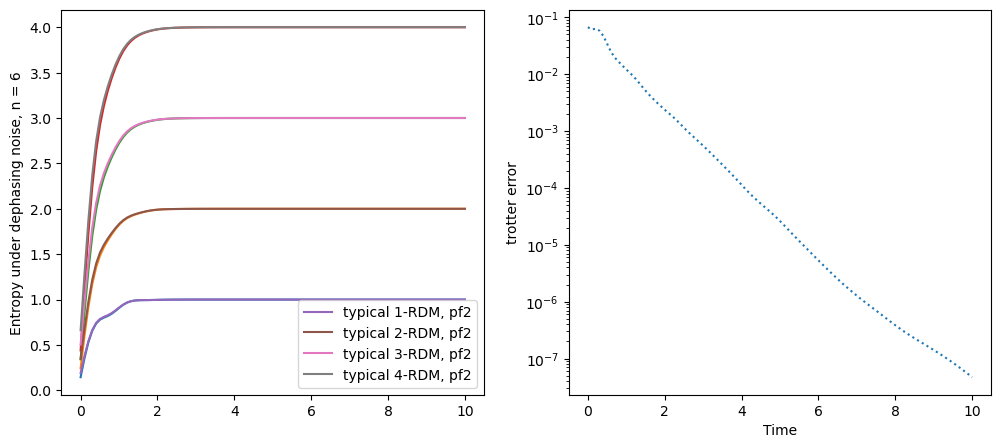

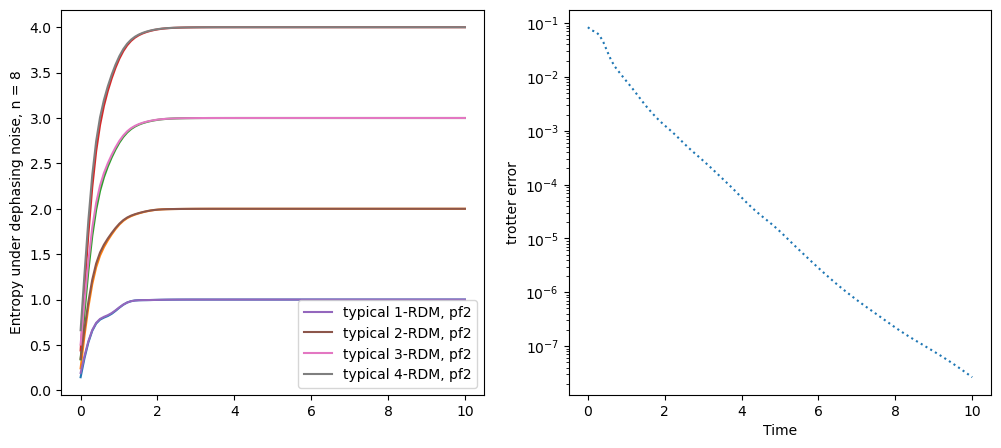

In [32]:
plot(entropy_list_6, entropy_list2_6, t_error_6, "dephasing", 6)
plot(entropy_list_8, entropy_list2_8, t_error_8, "dephasing", 8)


In [ ]:
error_x = pauli_error([('X', p_gate), ('I', 1 - p_gate)])  

n_6 = 6 # time = 3.16s 
H, init, n, r, m, dt, dt2 = init_system(n_6)
entropy_list_6, entropy_list2_6, t_error_6 = simulation(error_x, init, n_6, r, m, dt, dt2, H)

[SparsePauliOp(['IIIIXX', 'IIIXXI', 'IIXXII', 'IXXIII', 'XXIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 0.809+0.j,
 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j]), SparsePauliOp(['IIIIIY', 'IIIIYI', 'IIIYII', 'IIYIII', 'IYIIII', 'YIIIII'],
              coeffs=[0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j])]
0.1 0.1
0.0690866776387122
0.06223274122506066
0.06098596604185644
0.05408199495710584
0.041652653034000967
0.029886040142584374
0.02351432589091274
0.02077493319618642
0.017962232176115454
0.014643465500854934
0.011954449426756015
0.010302247623736304
0.009135391443404346
0.007982674250511263
0.006803234331701361
0.005698669277524191
0.00471971279220174
0.0038779661915911484
0.003199761524098024
0.0027158099043125914
0.002406149987742363
0.0021921818997490956
0.001997287414503256
0.0017896899433981236
0.0015740294672830519
0.0013665734615443052
0.0

In [ ]:
n_8 = 8 # time = 382.35s 
H, init, n, r, m, dt, dt2 = init_system(n_8)
entropy_list_8, entropy_list2_8, t_error_8 = simulation(error_x, init, n_8, r, m, dt, dt2, H)

[SparsePauliOp(['IIIIIIXX', 'IIIIIXXI', 'IIIIXXII', 'IIIXXIII', 'IIXXIIII', 'IXXIIIII', 'XXIIIIII', 'IIIIIIIX', 'IIIIIIXI', 'IIIIIXII', 'IIIIXIII', 'IIIXIIII', 'IIXIIIII', 'IXIIIIII', 'XIIIIIII'],
              coeffs=[1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j,
 1.   +0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j,
 0.809+0.j, 0.809+0.j, 0.809+0.j]), SparsePauliOp(['IIIIIIIY', 'IIIIIIYI', 'IIIIIYII', 'IIIIYIII', 'IIIYIIII', 'IIYIIIII', 'IYIIIIII', 'YIIIIIII'],
              coeffs=[0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j,
 0.9045+0.j, 0.9045+0.j])]
0.1 0.1
0.0834720176685993
0.0709900796574457
0.06508126707725347
0.053825143544582676
0.03882680708228785
0.026447134081682682
0.019998077226366436
0.01688613898739925
0.013890999651303014
0.010808064799075843
0.008463061435909422
0.007013080377842415
0.0059952157459195275
0.005076032513802051
0.004213448188623266
0.003446171355927539
0.002786850932115536
0.002236823201991203

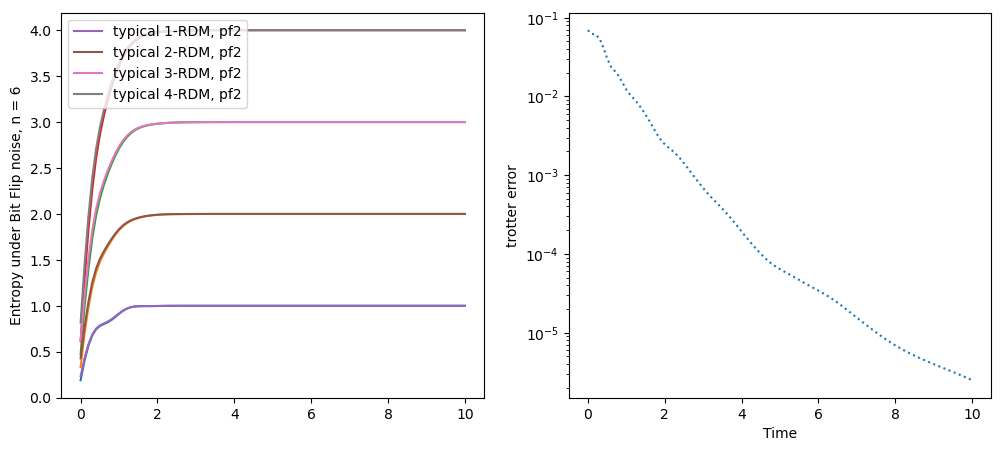

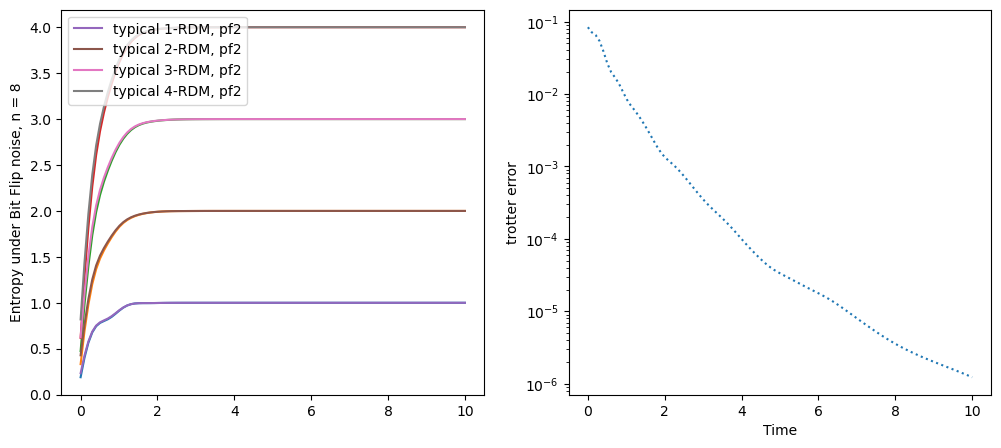

In [35]:
plot(entropy_list_6, entropy_list2_6, t_error_6, "Bit Flip", 6)
plot(entropy_list_8, entropy_list2_8, t_error_8, "Bit Flip", 8)

In [ ]:
error_depolarizing = depolarizing_error(p_gate, 1) 

n_6 = 6 # time = 3.43s 
H, init, n, r, m, dt, dt2 = init_system(n_6)
entropy_list_6, entropy_list2_6, t_error_6 = simulation(error_depolarizing, init, n_6, r, m, dt, dt2, H)

[SparsePauliOp(['IIIIXX', 'IIIXXI', 'IIXXII', 'IXXIII', 'XXIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 0.809+0.j,
 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j]), SparsePauliOp(['IIIIIY', 'IIIIYI', 'IIIYII', 'IIYIII', 'IYIIII', 'YIIIII'],
              coeffs=[0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j])]
0.1 0.1
0.06795802897228194
0.060588694369690145
0.058651002165991103
0.053525269489149374
0.043581534428852826
0.0334386429038658
0.02723842304802605
0.023832951182550886
0.0204403344131648
0.01687540346137961
0.014130712192159953
0.01229991675435722
0.010774955302521757
0.009278339068067215
0.007904230836599637
0.006756534720041111
0.005832652546781009
0.005068241241344864
0.004395864645429115
0.0037993533813541146
0.003308143560330522
0.002925701432618208
0.0026024669966057956
0.0022922117752183437
0.0019934549852339027
0.0017296503871588817
0.00

In [ ]:
n_8 = 8 # time = 409.71s 
H, init, n, r, m, dt, dt2 = init_system(n_8)
entropy_list_8, entropy_list2_8, t_error_8 = simulation(error_depolarizing, init, n_8, r, m, dt, dt2, H)

[SparsePauliOp(['IIIIIIXX', 'IIIIIXXI', 'IIIIXXII', 'IIIXXIII', 'IIXXIIII', 'IXXIIIII', 'XXIIIIII', 'IIIIIIIX', 'IIIIIIXI', 'IIIIIXII', 'IIIIXIII', 'IIIXIIII', 'IIXIIIII', 'IXIIIIII', 'XIIIIIII'],
              coeffs=[1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j,
 1.   +0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j,
 0.809+0.j, 0.809+0.j, 0.809+0.j]), SparsePauliOp(['IIIIIIIY', 'IIIIIIYI', 'IIIIIYII', 'IIIIYIII', 'IIIYIIII', 'IIYIIIII', 'IYIIIIII', 'YIIIIIII'],
              coeffs=[0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j,
 0.9045+0.j, 0.9045+0.j])]
0.1 0.1
0.08376234602953381
0.0706447988275512
0.06419600317716441
0.0551870711768228
0.04266112019776919
0.031398353526299924
0.024573686305613268
0.02046980462835447
0.016697680655597423
0.013202023177067741
0.010623742203381832
0.008844069673321561
0.007394294239546229
0.006117275022584073
0.005056733325280178
0.004209204062075014
0.0035187403570821826
0.00294941739703774
0

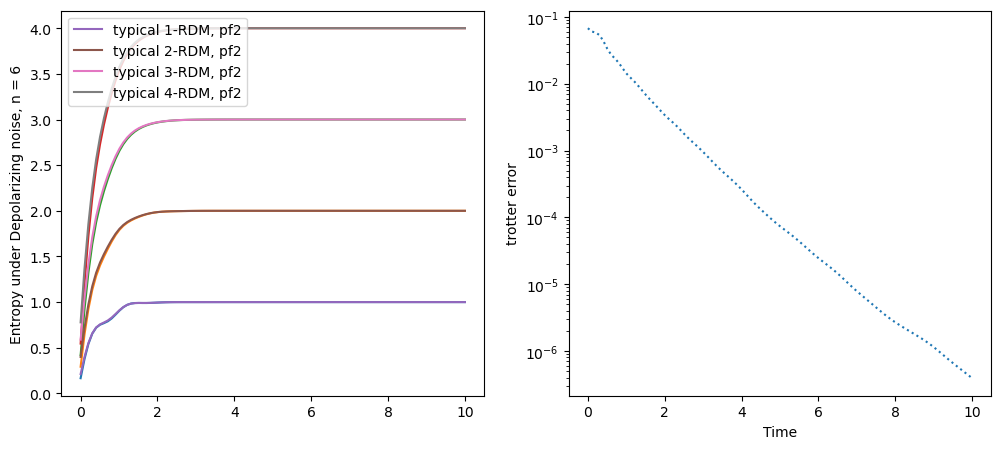

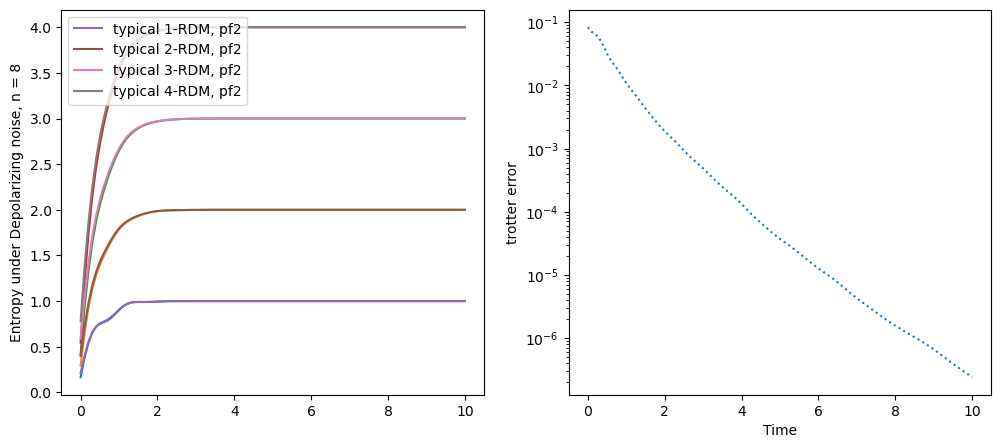

In [ ]:
plot(entropy_list_6, entropy_list2_6, t_error_6, "depolarizing", 6)
plot(entropy_list_8, entropy_list2_8, t_error_8, "depolarizing", 8)

In [19]:
!python --version

Python 3.8.13
